In [1]:
import numpy as np
import pandas as pd
import datetime
import math

In [2]:
#导入pnl曲线
historical_trading_data = pd.read_csv(r'C:\Users\Administrator\Desktop\pythonHistoricalTesting\code_generated_csv\historical_trading_data.csv',index_col=0)
historical_trading_data.head()

,CP_GMT,OrderType,CP_Lots,Symbol,CP_Price,StopLoss,TakeProfit,EP_GMT,EP_Price,InventoryFee,Profits
0,2018-04-18 13:30:00,Buy,1.0,USA30,24805.17,24705.17,24905.17,2018-04-19 12:45:00,24673.070,0.0,-132.100
1,2018-04-25 10:30:00,Sell,1.0,USA30,23965.07,24065.07,23865.07,2018-04-25 13:30:00,23839.670,0.0,125.400
2,2018-04-27 16:30:00,Sell,1.0,USA30,24279.17,24379.17,24179.17,2018-04-30 01:45:00,24385.469,0.0,-106.299
3,2018-04-27 19:30:00,Buy,1.0,USA30,24303.67,24203.67,24403.67,2018-04-30 05:15:00,24406.470,0.0,102.800
4,2018-04-27 19:45:00,Buy,1.0,USA30,24311.67,24211.67,24411.67,2018-04-30 05:30:00,24412.470,0.0,100.800


In [44]:
historical_trading_data

,CP_GMT,OrderType,CP_Lots,Symbol,CP_Price,StopLoss,TakeProfit,EP_GMT,EP_Price,InventoryFee,Profits
0,2018-04-18 13:30:00,Buy,1.0,USA30,24805.170,24705.170,24905.170,2018-04-19 12:45:00,24673.070,0.0,-132.100
1,2018-04-25 10:30:00,Sell,1.0,USA30,23965.070,24065.070,23865.070,2018-04-25 13:30:00,23839.670,0.0,125.400
2,2018-04-27 16:30:00,Sell,1.0,USA30,24279.170,24379.170,24179.170,2018-04-30 01:45:00,24385.469,0.0,-106.299
3,2018-04-27 19:30:00,Buy,1.0,USA30,24303.670,24203.670,24403.670,2018-04-30 05:15:00,24406.470,0.0,102.800
4,2018-04-27 19:45:00,Buy,1.0,USA30,24311.670,24211.670,24411.670,2018-04-30 05:30:00,24412.470,0.0,100.800
...,...,...,...,...,...,...,...,...,...,...,...
334,2020-11-16 07:30:00,Buy,1.0,USA30,29755.239,29655.239,29855.239,2020-11-16 11:45:00,29961.599,0.0,206.360
335,2020-11-16 19:45:00,Sell,1.0,USA30,29838.789,29938.789,29738.789,2020-11-16 20:45:00,29960.789,0.0,-122.000
336,2020-11-18 15:00:00,Buy,1.0,USA30,29875.999,29775.999,29975.999,2020-11-18 18:15:00,29738.779,0.0,-137.220
337,2020-11-18 15:15:00,Buy,1.0,USA30,29881.759,29781.759,29981.759,2020-11-18 18:15:00,29738.779,0.0,-142.980


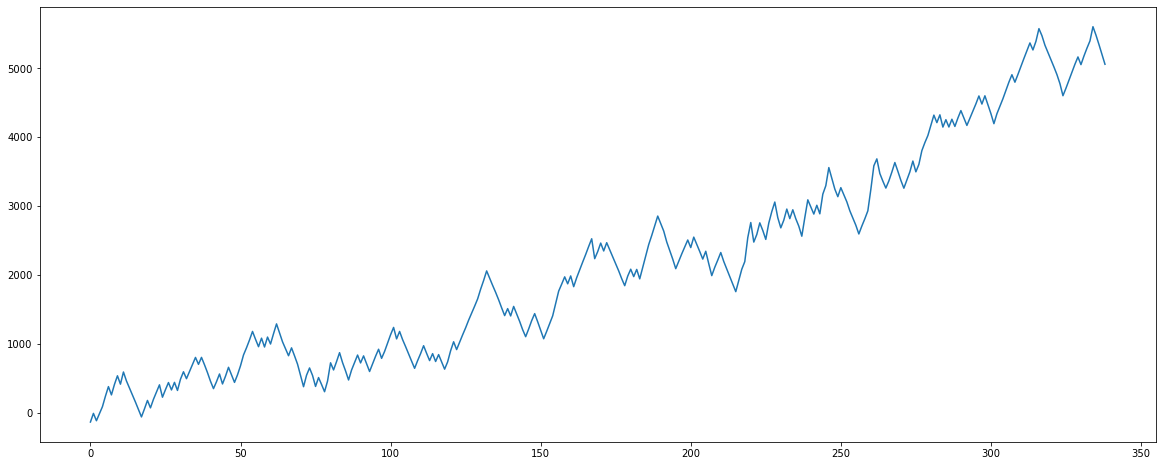

In [3]:
#pnl曲线
import matplotlib.pyplot as plt
plt.figure(figsize = (20,8))
plt.plot(np.cumsum(historical_trading_data.Profits))

In [57]:
(pd.to_datetime("2020-11-18 15:45:00") - pd.to_datetime("2020-11-16 07:30:00"))#<datetime.timedelta(days=3)

Timedelta('2 days 08:15:00')

In [4]:
# 需要记录Idx_start和Idx_low（Idx_low是通过找Idx_start和Idx_end之间的最小值得到的）
#计算Drawdown的函数，在BackTestingEvaluation中被调用
def CalcDrawDown(historical_trading_data):
    series = np.cumsum(historical_trading_data.Profits)#是pandas的series类型
    max_value = series.min()
    Idx = []
    for Idx_,item in zip(series.index,series.values):
        if (item > max_value):##考虑特殊情况，第一个即为最大值，事先写一个判断，如果曲线一直是向下的，就直接赋值一个-1或者别的常数值
            max_value = item
            Idx.append(Idx_)
    Idx_start = Idx[:-1]
    Idx_end = Idx[1:]
    drawdown_ratio_list = []
    drawdown_period_list = []
    for start,end in zip(Idx_start,Idx_end):
        previous_max = series[start]
        min_ = series[start:end].min()
        Idx_low = series[series.values == min_].index[0]
        drawdown_period = Idx_low - start
        drawdown_ratio = (min_ - previous_max)/previous_max
        drawdown_ratio_list.append(drawdown_ratio)
        drawdown_period_list.append(drawdown_period)
#         np.max(drawdown_period_list)
    return drawdown_ratio_list,drawdown_period_list

In [5]:
#遍历计算最大衰落的数值，并且记录时间点
def BackTestingEvaluation(historical_trading_data,rf,T,start_time,end_time):
    '''
    先要按照T来groupby，再把Profits累加，计算pnl的回落情况，排出最高的5个
    rf为年化的无风险利率
    T 可选day,week,month,其中day的有问题，可忽略
    start_time，测试的起始日期
    end_time，测试的终止日期
    
    '''
    lenth_of_time = pd.to_datetime(end_time) - pd.to_datetime(start_time)
    if T == "day":
        days = 1
    elif T == "week":
        days = 7
    else:
        days = 31
        
    if lenth_of_time < 4 * datetime.timedelta(days=days):
        return {"RAR":None,"R_cube":None,"Sharp_Ratio":None,"Robust_Sharp_Ratio":None}
    
    ##拼凑表格，添加天、周、月列
    table = historical_trading_data.copy()
    table = table.loc[(table.EP_GMT >= start_time) & (table.EP_GMT <= end_time)]

    table['date'] = [pd.to_datetime(table.EP_GMT).iloc[i].strftime('%Y-%m-%d') for i in range(len(table))]
    
    if T == "day":#这边如果要改进的话，也可以把初始的和最后的那些记录给删了，因为数据不完整
        mean_decay_period = 1/252
        table = table.iloc[1:-2]#删去第一条和最后一条可能数据有缺失的天
        pt = pd.pivot_table(table, values=['CP_Price', 'Profits'], index=['date'],
                        aggfunc={'CP_Price': np.mean,
                                 'Profits': np.sum})
        pt = pt.reset_index(drop = True)
        
    elif T == "week":
        mean_decay_period = 1/52

        start = pd.to_datetime(table.EP_GMT).iloc[0].strftime('%Y-%m-%d')
        end = (pd.to_datetime(table.EP_GMT).iloc[len(table)-1] + datetime.timedelta(days=7)).strftime('%Y-%m-%d')#
        w = pd.date_range(start = start, end = end, freq='W')    
        WeekTime1 = 0
        WeekTime2 = 1
        weektag = 1
        week = []
        for i in range(len(table)):
    #         print(week)

            if pd.to_datetime(table.loc[i].date) < w[WeekTime1]:
                week.append(0)
                continue
            elif (pd.to_datetime(table.loc[i].date) >= w[WeekTime1]) & (pd.to_datetime(table.loc[i].date) < w[WeekTime2]):
                week.append(weektag)
            else:
                week.append(weektag + 1)
                WeekTime1 += 1
                WeekTime2 += 1
                weektag += 1
        table['week'] = week
        #去掉标记为0的和weektag的（因为可能数据不全）
        table = table[(table.week != int(0)) & (table.week != int(weektag))]
        pt = pd.pivot_table(table, values=['CP_Price', 'Profits'], index=['week'],
                        aggfunc={'CP_Price': np.mean,
                                 'Profits': np.sum})
        pt = pt.reset_index(drop = True)
    else:
        mean_decay_period = 1/12
        start = pd.to_datetime(table.EP_GMT).iloc[0].strftime('%Y-%m-%d')
        end = (pd.to_datetime(table.EP_GMT).iloc[len(table)-1] + datetime.timedelta(days=31)).strftime('%Y-%m-%d')#
        m = pd.date_range(start = start, end = end, freq='M')
        MonthTime1 = 0
        MonthTime2 = 1
        monthtag = 1
        month = []
        for i in range(len(table)):
    #         print(week)

            if pd.to_datetime(table.loc[i].date) < m[MonthTime1]:
                month.append(0)
                continue
            elif (pd.to_datetime(table.loc[i].date) >= m[MonthTime1]) & (pd.to_datetime(table.loc[i].date) < m[MonthTime2]):
                month.append(monthtag)
            else:
                month.append(monthtag + 1)
                MonthTime1 += 1
                MonthTime2 += 1
                monthtag += 1
        table['month'] = month
        #去掉标记为0的和weektag的（因为可能数据不全）
        table = table[(table.month != int(0)) & (table.month != int(monthtag))]
        pt = pd.pivot_table(table, values=['CP_Price', 'Profits'], index=['month'],
                        aggfunc={'CP_Price': np.mean,
                                 'Profits': np.sum})
        pt = pt.reset_index(drop = True) 
    
#     print(pt)
    #计算夏普比率
    rate_of_return = (pt.Profits/pt.CP_Price)/mean_decay_period
    sharp_ratio = (np.mean(rate_of_return) - rf)/np.std(rate_of_return)
    
    ##设计算法，统计出5个最大回落，(后一个-前一个)/前一个,,,,貌似回落不是这么搞的，不然衰落期天数就没有意义了，或许还是有意义的，衰落期天数就是groupby的频率
    #先计算稳健风险回报率的分母
    value,period = CalcDrawDown(pt)
    import heapq
    pt_smallest5nums = heapq.nsmallest(5, value)
    sum_drawdown_period = []
    sum_drawdown_value = []
    for i,j in zip(value,period):
        if i in pt_smallest5nums:
            sum_drawdown_value.append(abs(i))
            sum_drawdown_period.append(j)
    average_drawdown_period_standardized = np.mean(sum_drawdown_period) * mean_decay_period
    denominator = np.mean(sum_drawdown_value) * average_drawdown_period_standardized   
    
    #计算分子，也就是RAR，确定start和end（算RAR最重要的就是拟合曲线的斜率）
    #确定起始时的资产价格（平均成本，随着测试时间段的加入，加入求平均的数会越来越大）
    import scipy.stats as st
    CAGR = []
    for m in range(len(pt)):
        period_avg_cost_sub = pt.CP_Price.iloc[:(m + 1)].mean()
        real_time_value_sub = pt.CP_Price.iloc[0] + pt.Profits.iloc[:(m + 1)].sum()
        CAGR.append((real_time_value_sub/period_avg_cost_sub)**(1/((m + 1)*mean_decay_period)) - 1)
        
    slope, intercept, r_value, p_value, std_err = st.linregress(range(len(CAGR)), CAGR)
    RAR = slope * len(CAGR) + intercept     
    
    #计算稳健风险回报比率，R立方
    R_cube = RAR/denominator   
    
    #计算稳健夏普比率，书上定义的分母为年度化的月度回报标准差，我下面根据输入的周期进行年度化
    Robust_Sharp_Ratio = RAR/np.std(rate_of_return)   
    
    
#     period_avg_cost = pt.CP_Price.rolling(window=int(1/mean_decay_period)).mean()
#     print(period_avg_cost)
#     period_total_profits = pt.Profits.rolling(window=int(1/mean_decay_period)).sum()
#     r = period_total_profits/period_avg_cost
#     r = [math.pow((j + i)/j,mean_decay_period)-1 for i,j in zip(period_total_profits,period_avg_cost)]
#     r = [x for x in r if str(x) != 'nan']
#     print(r)
#     import scipy.stats as st
    #注意什么时候需要np.cumsum什么时候不需要
#     slope, intercept, r_value, p_value, std_err = st.linregress(range(len(pt.Profits)), np.cumsum(pt.Profits))

#     slope, intercept, r_value, p_value, std_err = st.linregress(range(len(r)), r)   
    #计算这一period的RAR，这边要注意，要转化成年的
#     delta = slope * len(pt.Profits)
#     RAR = slope * len(r) + intercept
#     RAR = delta/np.mean(pt.CP_Price)#算RAR去体会一下把直线拉长的算法，而不是简单地线性回归，RAR是不是去拟合回报率的？先得画出年度回报率的散点图，再去拟合
#     RAR_not_standardized = delta/np.mean(pt.CP_Price)
#     RAR = RAR_not_standardized * (mean_decay_period * len(pt.Profits))

#     print(denominator,slope,intercept)
    
    return {"RAR":RAR,"R_cube":R_cube,"Sharp_Ratio":sharp_ratio,"Robust_Sharp_Ratio":Robust_Sharp_Ratio}#这边返回一个字典，为后续滚动以append到dataframe中提供便利

In [31]:
index4 = BackTestingEvaluation(historical_trading_data,0,T = "week",start_time = "2018-04-18 13:30:00",end_time = "2020-11-18 15:45:00")

In [32]:
index4

{'RAR': 0.02882946502231592,
 'R_cube': 0.6025707431703401,
 'Sharp_Ratio': 0.18487476614414539,
 'Robust_Sharp_Ratio': 0.06322083057468629}

In [10]:
index4["Sharp_Ratio"]

0.1737914472308742

In [11]:
start = pd.to_datetime(historical_trading_data.EP_GMT).iloc[0].strftime('%Y-%m-%d')
end = pd.to_datetime(historical_trading_data.EP_GMT).iloc[-1].strftime('%Y-%m-%d')
w = pd.date_range(start = start, end = end, freq='W')
w

DatetimeIndex(['2018-04-22', '2018-04-29', '2018-05-06', '2018-05-13',
               '2018-05-20', '2018-05-27', '2018-06-03', '2018-06-10',
               '2018-06-17', '2018-06-24',
               ...
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',
               '2020-11-08', '2020-11-15'],
              dtype='datetime64[ns]', length=135, freq='W-SUN')

In [49]:
week_sharp = []
for i in range(40,len(w)):
    week_sharp_sub = BackTestingEvaluation(historical_trading_data,0,T = "week",start_time = "2018-04-18",end_time = w[i].strftime('%Y-%m-%d'))
    week_sharp.append(week_sharp_sub["Sharp_Ratio"])

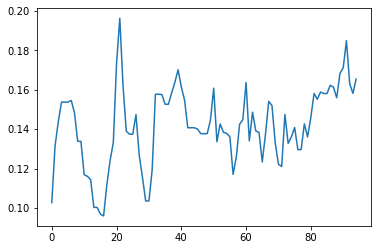

In [50]:
import matplotlib.pyplot as plt
plt.plot(week_sharp)

## 下面为之前写的代码，可忽略

In [7]:
#按照日groupby来计算sharpratio
def SharpRatioDay(history,rf = 0):
    '''
    history为历史交易记录表，rf为无风险利率，默认为0
    '''
    sharpdata = history.copy()
    sharpdata['date'] = [sharpdata.EP_GMT.loc[i].strftime('%Y-%m-%d') for i in range(len(sharpdata))]
    sharpdata
    table = pd.pivot_table(sharpdata, values=['CP_Price', 'Profits'], index=['date'],
                        aggfunc={'CP_Price': np.mean,
                                 'Profits': np.sum})
    rate_of_return = table.Profits/table.CP_Price

    sharpratio = (rate_of_return.mean() - rf)/rate_of_return.std()
    return sharpratio

In [8]:
#按照周groupby来计算sharpratio
def SharpRatioWeek(history,rf = 0):
    '''
    history为历史交易记录表，rf为无风险利率，默认为0
    '''
    sharpdata = history.copy()
    sharpdata['date'] = [sharpdata.EP_GMT.loc[i].strftime('%Y-%m-%d') for i in range(len(sharpdata))]
    sharpdata['date'] = pd.to_datetime(sharpdata.date)
    start = sharpdata.EP_GMT.loc[0].strftime('%Y-%m-%d')
    end = (sharpdata.EP_GMT.loc[len(sharpdata)-1] + datetime.timedelta(days=7)).strftime('%Y-%m-%d')#这边可以再加7天
    d = pd.date_range(start = start, end = end, freq='W')
#     print(d)
    DateTime1 = 0
    DateTime2 = 1
    weektag = 1
    week = []
    for i in range(len(sharpdata)):
#         print(week)
    
        if sharpdata.loc[i].date < d[DateTime1]:
            week.append(0)
            continue
        elif (sharpdata.loc[i].date >= d[DateTime1]) & (sharpdata.loc[i].date < d[DateTime2]):
            week.append(weektag)
        else:
            week.append(weektag + 1)
            DateTime1 += 1
            DateTime2 += 1
            weektag += 1
    sharpdata['week'] = week
    #去掉标记为0的和weektag的（因为可能数据不全）
    sharpdata = sharpdata[(sharpdata.week != int(0)) & (sharpdata.week != int(weektag))]
    table = pd.pivot_table(sharpdata, values=['CP_Price', 'Profits'], index=['week'],
                        aggfunc={'CP_Price': np.mean,
                                 'Profits': np.sum})
    rate_of_return = table.Profits/table.CP_Price

    sharpratio = (rate_of_return.mean() - rf)/rate_of_return.std()
    return sharpratio